In [132]:
# Download Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("risangbaskoro/wlasl-processed")

print("Path to dataset files:", path)

# new dataset name
org_dir = 'videos_org'
org_path = path + '/' + org_dir

print(org_path)

# !source activate video
# !python utils/reorg.py {org_dir} 0

Path to dataset files: /home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5
/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos_org


In [124]:
!git clone https://github.com/whwu95/MVFNet.git

Cloning into 'MVFNet'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (310/310), done.
remote: Compressing objects: 100% (214/214), done.
remote: Total 310 (delta 113), reused 273 (delta 87), pack-reused 0 (from 0)
Receiving objects: 100% (310/310), 20.42 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [133]:

directory = 'wlasl_10'
resized_dir = path + '/resized_' + directory
frame_dir = path + '/frames_' + directory
print(resized_dir)
print(frame_dir)

/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/resized_wlasl_10
/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10


In [135]:
!python MVFNet/data_process/video_resize.py {org_path} {resized_dir} --level 2 -se 256
!python MVFNet/data_process/video2image.py {resized_dir} {frame_dir} --level 2 --lib opencv --prefix image_%04d.jpg
!rm -r {resized_dir}
!rm -r ./MVFNet

100%|█████████████████████████████████████| 11980/11980 [02:33<00:00, 78.12it/s]
rm: remove write-protected regular file './MVFNet/.git/objects/pack/pack-8a73c7a021b9c4c83a2451ad2d45e4964b67632d.idx'? ^C


In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import random


# !export XLA_FLAGS=--xla_gpu_cuda_data_dir="/home/tkg5kq/.conda/envs/video/lib/python3.11/site-packages/triton/third_party/cuda/bin"

2024-12-12 13:57:45.009833: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 13:57:45.012189: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 13:57:45.043298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 13:57:45.044047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 13:57:46.157749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [29]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results  = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [30]:
def draw_styled_landmarks(image, results, mp_drawing, mp_holistic):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [46]:
seed = 100
random.seed(seed)
num_classes = 10
frames_path = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/frames_wlasl_10'
image_height = 64
image_width = 80

classes = ['love', 'thankyou', 'face', 'no', 'thin', 'man', 'woman', 'cousin', 'deaf', 'no', 'who', 'help'] 
# classes = os.listdir(frames_path)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

I0000 00:00:1734031496.023132   34031 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734031496.069346   48595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA A40/PCIe/SSE2
W0000 00:00:1734031496.119060   48509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734031496.134412   48578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734031496.135981   48539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734031496.137159   48549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734031496.13

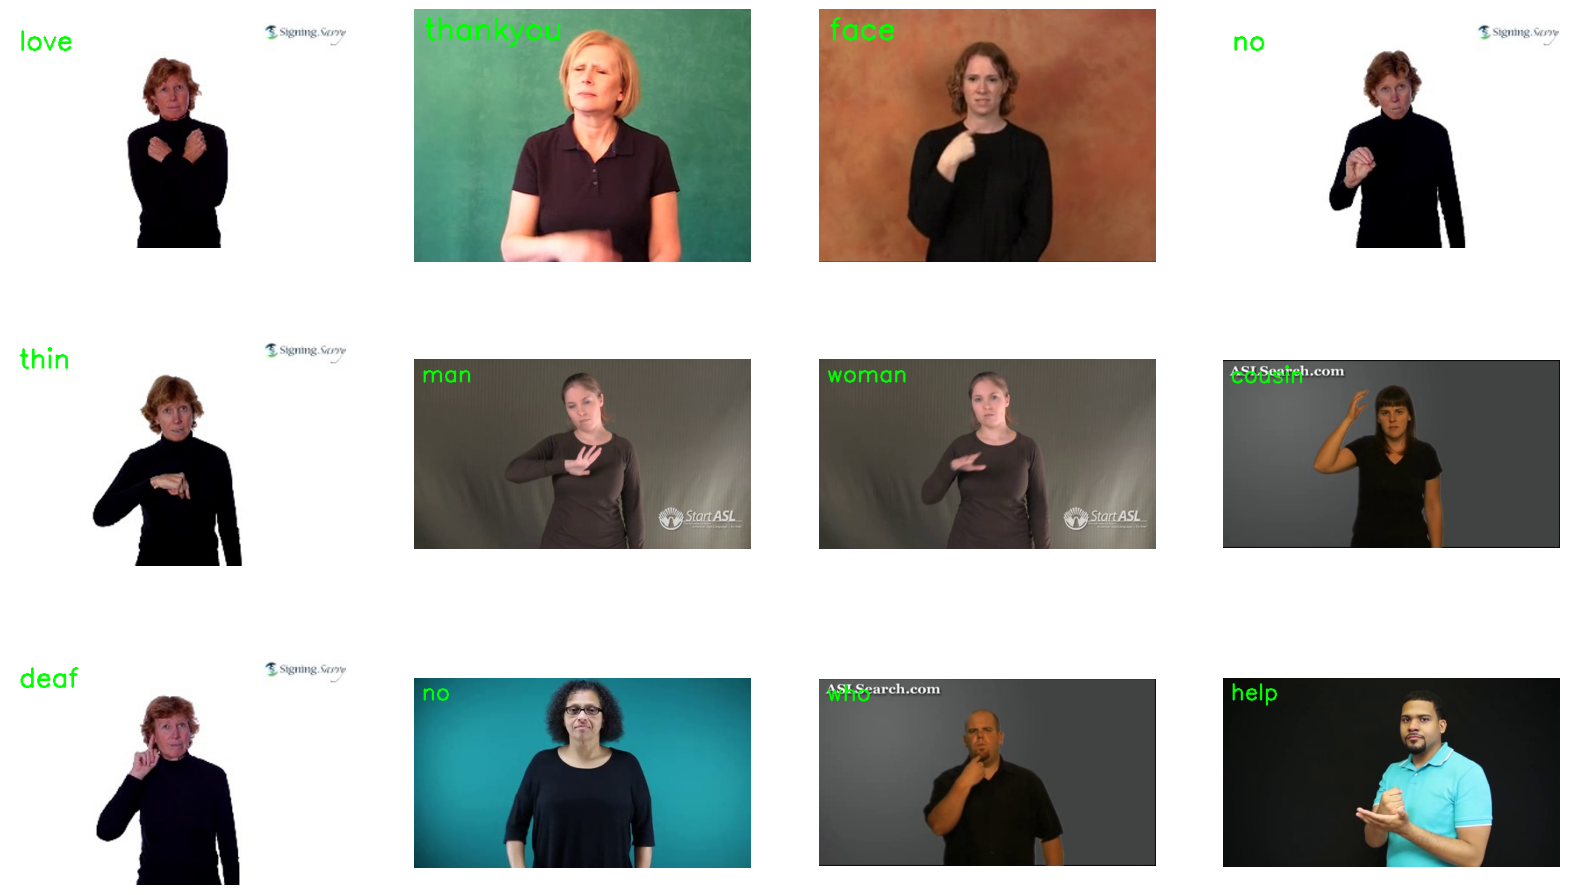

In [56]:
plt.figure(figsize=(20,20))
random_range = random.sample(range(len(classes)), num_classes)

frames = []
results_list = []
for counter, selected_class_name in enumerate(classes):
    video_files_names_list = os.listdir(os.path.join(frames_path, selected_class_name))

    selected_video_file_name = random.choice(video_files_names_list)

    video_frame_path = os.path.join(frames_path, selected_class_name, selected_video_file_name)
    video_frame_list = os.listdir(video_frame_path)

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        idx = 0
        # print(video_frame_list[0])
        frame_path = os.path.join(frames_path, selected_class_name, selected_video_file_name, video_frame_list[0])
        # print(frame_path)
        bgr_frame = cv2.imread(frame_path)
        bgr_frame, results = mediapipe_detection(bgr_frame, holistic)
        frames.append(bgr_frame)
        results_list.append(results)

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    plt.subplot(5, 4, counter+1); plt.imshow(rgb_frame); plt.axis('off')

plt.show()

# load_video_dataset('/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5/videos_org')



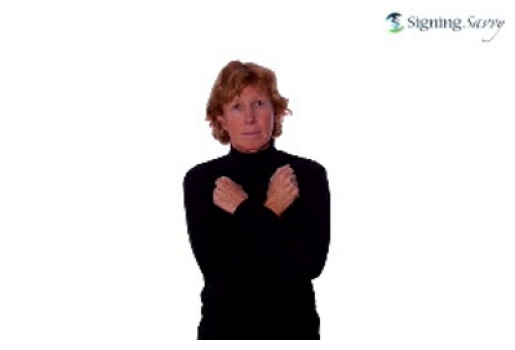

In [60]:
rgb_frame = cv2.cvtColor(frames[0], cv2.COLOR_RGB2BGR)
plt.imshow(rgb_frame)
plt.axis('off')
plt.show()

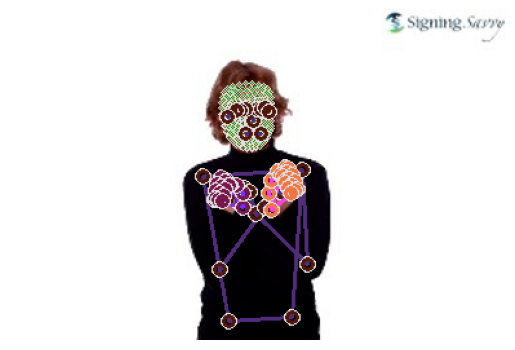

In [59]:
from copy import deepcopy

image = deepcopy(rgb_frame)

draw_styled_landmarks(image, results_list[0], mp_drawing, mp_holistic)
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
face_list_len = len(results.face_landmarks.landmark) if results.face_landmarks else 0
left_list_len = len(results.left_hand_landmarks.landmark) if results.left_hand_landmarks else 0
right_list_len = len(results.right_hand_landmarks.landmark) if results.right_hand_landmarks else 0
pose_list_len = len(results.pose_landmarks.landmark) if results.pose_landmarks else 0

NameError: name 'results' is not defined

In [4]:
# print(face_list_len, left_list_len, right_list_len, pose_list_len)
FACE_LIST_LEN = 468
LEFT_LIST_LEN = 21
RIGHT_LIST_LEN = 21
POSE_LIST_LEN = 33

TOTAL_LIST_LEN = FACE_LIST_LEN*3 + LEFT_LIST_LEN*3 + RIGHT_LIST_LEN*3 + POSE_LIST_LEN*4
print(TOTAL_LIST_LEN)

1662


In [113]:
for landmark in results.pose_landmarks.landmark:
    print(landmark.x)
    print(landmark.y)
    print(landmark.z)
    print(landmark.visibility)
    break


0.501240611076355
0.2738470733165741
-0.6756582260131836
0.9999323487281799


In [15]:
def extract_landmarks(results):
    pose = np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(POSE_LIST_LEN*4)
    face = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.face_landmarks.landmark]).flatten()  if results.face_landmarks else np.zeros(FACE_LIST_LEN*3)
    left = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(LEFT_LIST_LEN*3)
    right = np.array([[landmark.x, landmark.y, landmark.z] for landmark in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(RIGHT_LIST_LEN*3)
    return np.concatenate([pose, face, left, right])

In [115]:
landmarks = extract_landmarks(results)
len(landmarks), TOTAL_LIST_LEN

(1662, 1662)

In [76]:
landmarks

array([ 0.46669739,  0.27084452, -0.90979624, ...,  0.47650486,
        0.77135903,  0.0021462 ])

# Extract Data

Create a folder path and collect the numpy array of extracted pose, face, left hand, and right hand data. 

In [16]:
path = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5'
frames_path = os.path.join(path, 'frames_wlasl_10')
poses_path = os.path.join(path, 'poses')
os.makedirs(poses_path, exist_ok=True)
classes = ['help', 'soon']
for count, class_name in enumerate(classes):
    class_path = f'{frames_path}/{class_name}'

    os.makedirs(f'{poses_path}/{class_name}', exist_ok=True)

    video_name_list = os.listdir(class_path)

    for video in video_name_list:
        video_path = f'{class_path}/{video}'

        frame_list = os.listdir(video_path)
        os.makedirs(f'{poses_path}/{class_name}/{video}', exist_ok=True)

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            for frame in frame_list:
                frame_path = f'{class_path}/{video}/{frame}'
                extracted_path = f'{poses_path}/{class_name}/{video}/{frame.split(".")[0].split("_")[-1]}'
                bgr_frame, results = mediapipe_detection(cv2.imread(frame_path), holistic) #hands.process(cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB))
                landmarks = extract_landmarks(results)
                # rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
                np.save(extracted_path, landmarks)
    # if count == 9:
    #     break

I0000 00:00:1734029758.948005   31919 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1734029758.993987   33313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.54.14), renderer: NVIDIA A40/PCIe/SSE2
W0000 00:00:1734029759.041791   33218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734029759.060564   33292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734029759.062167   33304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734029759.062909   33292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1734029759.07

KeyboardInterrupt: 

# Preprocessing

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
# Create a label map

classes = ['love', 'thankyou', 'face', 'no', 'thin', 'man', 'woman', 'cousin', 'deaf', 'no', 'who'] #, 'leave']

label_map = {label:num for num, label in enumerate(classes)}
label_map

{'love': 0,
 'thankyou': 1,
 'face': 2,
 'no': 9,
 'thin': 4,
 'man': 5,
 'woman': 6,
 'cousin': 7,
 'deaf': 8,
 'who': 10}

## Load the data

In [7]:
import os
path = '/home/tkg5kq/.cache/kagglehub/datasets/risangbaskoro/wlasl-processed/versions/5'
poses_path = os.path.join(path, 'poses')
sequences, labels = [], []
pose_lens = []
sample_num = 20
samples_per_video = 10
for count, class_name in enumerate(classes):
    class_path = f'{poses_path}/{class_name}'

    video_name_list = os.listdir(class_path)

    for vid_cnt, video in enumerate(video_name_list):
        if (vid_cnt) > 7:
            break
        window = []
        video_path = f'{class_path}/{video}'

        poses_list = os.listdir(video_path)

        window = np.empty((len(poses_list), TOTAL_LIST_LEN))
        for pose_cnt, pose in enumerate(poses_list):

            pose_path = f'{video_path}/{pose}'
            res = np.load(pose_path)

            window[pose_cnt] = res

        for _ in range(samples_per_video):
            # print(pose_cnt, np.array(window).shape)
            random_sequence = sorted(random.sample(range(pose_cnt+1), 20))
            # print(random_sequence)
            new_window = window[random_sequence, :]
            sequences.append(new_window)
            labels.append(label_map[class_name])

In [8]:
np.array(sequences).shape

(860, 20, 1662)

In [9]:
np.array(labels).shape

(860,)

In [15]:
np.array(labels)
y = to_categorical(labels).astype(int)
print(y)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [16]:
seed =100
X_train, X_test, y_train, y_test = train_test_split(np.array(sequences), y, test_size=0.2, random_state=seed)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((688, 20, 1662), (688, 11), (172, 20, 1662), (172, 11))

The data is now created and set up. It is time to train the neural network

## LSTM NN

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense # fully connected layer
from tensorflow.keras.callbacks import TensorBoard

In [43]:
import os
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [44]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos])
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:CPU:0']


2024-12-12 10:55:00.528873: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [45]:
import tensorflow as tf

tf.random.set_seed(seed)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(np.array(classes).shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, y_train, epochs=95, callbacks=[tb_callback])

# print(X_train.shape, y_train.shape)
# ['love', 'thankyou', 'face']                                                              --> 100: 93.181818%
# ['love', 'thankyou', 'face', 'no']                                                        --> 80: 56.666667%
# ['love', 'thankyou', 'face', 'no', 'thin', 'man', 'woman', 'cousin', 'deaf', 'no'] --> 200: 50.000000%, 110: 64.743590%, 95: 56.410256%, 80: 42.307692%
# ['love', 'thankyou', 'face', 'no', 'thin', 'man', 'woman', 'cousin', 'deaf', 'no', 'who'] --> 95: 55.232558%, 80: 47.093023%
# ['love', 'thankyou', 'face', 'no', 'thin', 'man', 'woman', 'cousin', 'deaf', 'no', 'who', 'help'] --> 400: 76.063830%, 350: 78.191489%, 325: 75.531915%, 300: 74.468085%, 150: 70.212766%, 100: 63.829787%


Epoch 1/95
22/22 [==============================] - 2s 17ms/step - loss: 2.3676 - categorical_accuracy: 0.1337
Epoch 2/95
22/22 [==============================] - 0s 16ms/step - loss: 2.2887 - categorical_accuracy: 0.1831
Epoch 3/95
22/22 [==============================] - 0s 17ms/step - loss: 2.1747 - categorical_accuracy: 0.2267
Epoch 4/95
22/22 [==============================] - 0s 16ms/step - loss: 2.0752 - categorical_accuracy: 0.2529
Epoch 5/95
22/22 [==============================] - 0s 16ms/step - loss: 1.9826 - categorical_accuracy: 0.2994
Epoch 6/95
22/22 [==============================] - 0s 16ms/step - loss: 1.9442 - categorical_accuracy: 0.2762
Epoch 7/95
22/22 [==============================] - 0s 16ms/step - loss: 1.9576 - categorical_accuracy: 0.2907
Epoch 8/95
22/22 [==============================] - 0s 16ms/step - loss: 1.9233 - categorical_accuracy: 0.2820
Epoch 9/95
22/22 [==============================] - 0s 16ms/step - loss: 1.8999 - categorical_accuracy: 0.3081
E

6/6 [==============================] - 0s 6ms/step
Confusion matrix, without normalization


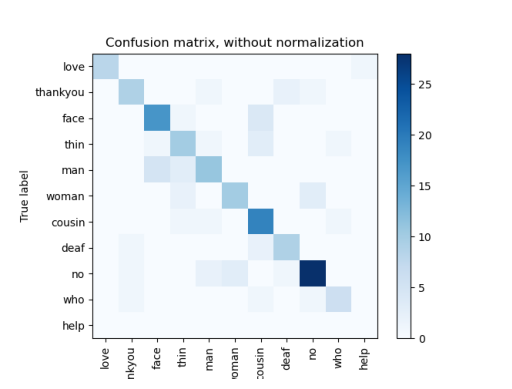

Accuracy Score: 73.83720930232558%


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense # fully connected layer
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

classes = ['love', 'thankyou', 'face', 'no', 'thin', 'man', 'woman', 'cousin', 'deaf', 'no', 'who', 'help'] 

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.xticks(rotation=90)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #          rotation_mode="anchor")

    # # Loop over data dimensions and create text annotations.
    # fmt = '.2f' if normalize else 'd'
    # thresh = cm.max() / 2.
    # for i in range(cm.shape[0]):
    #     for j in range(cm.shape[1]):
    #         ax.text(j, i, format(cm[i, j], fmt),
    #                 ha="center", va="center",
    #                 color="white" if cm[i, j] > thresh else "black")
    # fig.tight_layout()
    # plt.xlim(-0.5, len(np.unique(y))-0.5)
    # plt.ylim(len(np.unique(y))-0.5, -0.5)
    plt.savefig('confusion_matrix.png')
    plt.clf()

def create_model(classes):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(20,1662)))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, return_sequences=False, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(np.array(classes).shape[0], activation='softmax'))
    return model

model = create_model(classes)
model.load_weights('action.h5')
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).astype(int).tolist()
yhat = np.argmax(yhat, axis=1).astype(int).tolist()

plot_confusion_matrix(ytrue, yhat, np.array(classes))

image = cv2.imread("confusion_matrix.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()

accuracy = accuracy_score(ytrue, yhat)
print(f'Accuracy Score: {accuracy*100}%')

In [46]:
res = model.predict(X_test)

6/6 [==============================] - 0s 6ms/step


In [47]:
print(f'{(np.sum([classes[np.argmax(res[idx])] == classes[np.argmax(y_test[idx])] for idx in range(len(res))])/len(res))*100:02f}%')

48.837209%
